# Image generation with Latent Consistency Model and OpenVINO

LCMs: The next generation of generative models after Latent Diffusion Models (LDMs). 
Latent Diffusion models (LDMs) have achieved remarkable results in synthesizing high-resolution images. However, the iterative sampling is computationally intensive and leads to slow generation.

Inspired by [Consistency Models](https://arxiv.org/abs/2303.01469), [Latent Consistency Models](https://arxiv.org/pdf/2310.04378.pdf) (LCMs) were proposed, enabling swift inference with minimal steps on any pre-trained LDMs, including Stable Diffusion. 
The [Consistency Model (CM) (Song et al., 2023)](https://arxiv.org/abs/2303.01469) is a new family of generative models that enables one-step or few-step generation. The core idea of the CM is to learn the function that maps any points on a trajectory of the PF-ODE (probability flow of [ordinary differential equation](https://en.wikipedia.org/wiki/Ordinary_differential_equation)) to that trajectory’s origin (i.e., the solution of the PF-ODE). By learning consistency mappings that maintain point consistency on ODE-trajectory, these models allow for single-step generation, eliminating the need for computation-intensive iterations. However, CM is constrained to pixel space image generation tasks, making it unsuitable for synthesizing high-resolution images. LCMs adopt a consistency model in the image latent space for generation high-resolution images.  Viewing the guided reverse diffusion process as solving an augmented probability flow ODE (PF-ODE), LCMs are designed to directly predict the solution of such ODE in latent space, mitigating the need for numerous iterations and allowing rapid, high-fidelity sampling. Utilizing image latent space in large-scale diffusion models like Stable Diffusion (SD) has effectively enhanced image generation quality and reduced computational load. The authors of LCMs provide a simple and efficient one-stage guided consistency distillation method named Latent Consistency Distillation (LCD) to distill SD for few-step (2∼4) or even 1-step sampling and propose the SKIPPING-STEP technique to further accelerate the convergence. More details about proposed approach and models can be found in [project page](https://latent-consistency-models.github.io/), [paper](https://arxiv.org/abs/2310.04378) and [original repository](https://github.com/luosiallen/latent-consistency-model).

In this tutorial, we consider how to convert and run LCM using OpenVINO. An additional part demonstrates how to run quantization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline and generate images using [OpenVINO GenAI](https://github.com/openvinotoolkit/openvino.genai).

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert models to OpenVINO format](#Convert-models-to-OpenVINO-format)
- [Prepare inference pipeline](#Prepare-inference-pipeline)
    - [Configure Inference Pipeline](#Configure-Inference-Pipeline)
- [Text-to-image generation](#Text-to-image-generation)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
    - [Compare UNet file size](#Compare-UNet-file-size)
- [Run Text to image generation using OpenVINO GenAI](#Run-Text-to-image-generation-using-OpenVINO-GenAI)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/latent-consistency-models-image-generation/latent-consistency-models-image-generation.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q "torch>=2.1" --index-url https://download.pytorch.org/whl/cpu
%pip install -q "transformers>=4.45" tqdm accelerate "diffusers>=0.30.1" pillow "gradio>=4.19" "nncf>=2.12.0" "datasets>=2.14.6" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -qU --pre  "openvino>=2024.4.0" "openvino-tokenizers" "openvino-genai" --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly

In [2]:
from pathlib import Path
import requests

utility_files = [Path("notebook_utils.py"), Path("skip_kernel_extension.py"), Path("cmd_helper.py")]

base_utils_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/"

for utility_file in utility_files:
    if not utility_file.exists():
        r = requests.get(base_utils_url + utility_file.name)
        with utility_file.open("w") as f:
            f.write(r.text)

## Convert models to OpenVINO format
[back to top ⬆️](#Table-of-contents:)

In this tutorial we will use [LCM_Dreamshaper_v7](https://huggingface.co/SimianLuo/LCM_Dreamshaper_v7) from [HuggingFace hub](https://huggingface.co/). This model distilled from [Dreamshaper v7](https://huggingface.co/Lykon/dreamshaper-7) fine-tune of [Stable-Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) using Latent Consistency Distillation (LCD) approach discussed above. This model is also integrated into [Diffusers](https://huggingface.co/docs/diffusers/index) library. 🤗 Diffusers is the go-to library for state-of-the-art pretrained diffusion models for generating images, audio, and even 3D structures of molecules. This allows us to compare running original Stable Diffusion (from this [notebook](../stable-diffusion-text-to-image/stable-diffusion-text-to-image.ipynb)) and distilled using LCD. The distillation approach efficiently converts a pre-trained guided diffusion model into a latent consistency model by solving an augmented PF-ODE.

For simplifying model export we will utilize Optimum Intel library. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use [interface](https://huggingface.co/docs/optimum/intel/openvino/export) for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

The command bellow demonstrates basic command for model export with `optimum-cli`

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <out_dir>
```

where `--model` argument is model id from HuggingFace Hub or local directory with model (saved using `.save_pretrained` method), `--task ` is one of [supported task](https://huggingface.co/docs/optimum/exporters/task_manager) that exported model should solve. For image generation it will be `text-to-image`. If model initialization requires to use remote code, `--trust-remote-code` flag additionally should be passed. You can also apply fp16, 8-bit or 4-bit weight compression on the Linear, Convolutional and Embedding layers when exporting your model with the CLI by setting `--weight-format` to respectively fp16, int8 or int4. This type of optimization allows to reduce the memory footprint and inference latency. We will quantize our model later using nncf, so in this step we will use fp16 as base model export precision.

In [3]:
from cmd_helper import optimum_cli

model_id = "SimianLuo/LCM_Dreamshaper_v7"
model_path = Path(model_id.split("/")[-1] + "_ov")

if not model_path.exists():
    optimum_cli(model_id, model_path, additional_args={"weight-format": "fp16"})

## Prepare inference pipeline
[back to top ⬆️](#Table-of-contents:)

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.

![lcm-pipeline](https://user-images.githubusercontent.com/29454499/277402235-079bacfb-3b6d-424b-8d47-5ddf601e1639.png)

The pipeline takes a latent image representation and a text prompt is transformed to text embedding via CLIP's text encoder as an input. The initial latent image representation generated using random noise generator. In difference, with original Stable Diffusion pipeline, LCM also uses guidance scale for getting timestep conditional embeddings as input for diffusion process, while in Stable Diffusion, it used for scaling output latents.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. LCM introduces own scheduling algorithm that extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with non-Markovian guidance.
The *denoising* process is repeated given number of times (by default 50 in original SD pipeline, but for LCM small number of steps required ~2-8) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

For starting work with LCM, we should instantiate the generation pipeline first. `DiffusionPipeline.from_pretrained` method downloads all pipeline components (if required) for LCM and configure them. Loading LCM for OpenVINO inference using Optimum Intel looks similar, we only should replace `DiffusionPipeline` with `OVDiffusionPpeline`. This model class accepts model id from HuggingFace Hub or local directory for original PyTorch pipeline or already converted. In case, if path to original pipeline provided, it will be automatically converted to OpenVINO format, but as we already converted model before using Optimum CLI, we will use models from the previous step. 

### Configure Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

Optionally, we can setup which device will be used for running inference. Select desired inference device from dropdown list bellow.

In [4]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [5]:
from optimum.intel.openvino import OVDiffusionPipeline

ov_pipe = OVDiffusionPipeline.from_pretrained(model_path, device=device.value)

2024-11-14 12:52:11.556586: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 12:52:11.570192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731574331.585339 2056327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731574331.589784 2056327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 12:52:11.606540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model tokenizer and scheduler are also important parts of the pipeline. This pipeline is also can use Safety Checker, the filter for detecting that corresponding generated image contains "not-safe-for-work" (nsfw) content. The process of nsfw content detection requires to obtain image embeddings using CLIP model, so additionally feature extractor component should be added in the pipeline. We reuse tokenizer, feature extractor, scheduler and safety checker from original LCM pipeline.

## Text-to-image generation
[back to top ⬆️](#Table-of-contents:)

Now, let's see model in action

In [6]:
import torch

prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4

images = ov_pipe(
    prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=8.0, height=512, width=512, generator=torch.Generator().manual_seed(1234567)
).images

  0%|          | 0/4 [00:00<?, ?it/s]

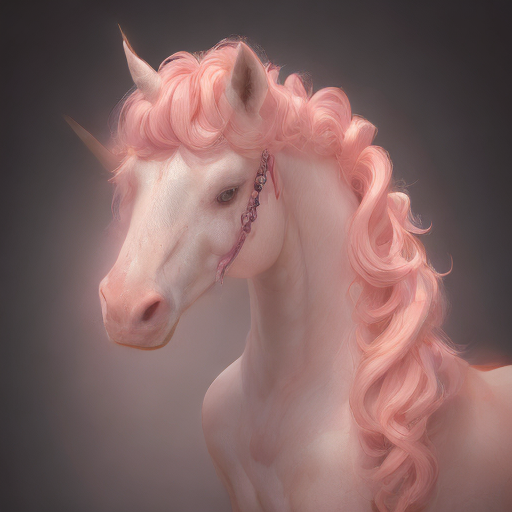

In [7]:
images[0]

Nice. As you can see, the picture has quite a high definition 🔥.

In [8]:
import gc

del ov_pipe
gc.collect();

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `LatentConsistencyModelPipeline` structure, UNet used for iterative denoising of input. It means that model runs in the cycle repeating inference on each diffusion step, while other parts of pipeline take part only once. That is why computation cost and speed of UNet denoising becomes the critical path in the pipeline. Quantizing the rest of the SD pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [9]:
from notebook_utils import quantization_widget

skip_for_device = "GPU" in device.value
to_quantize = quantization_widget(not skip_for_device)
int8_model_path = model_path.parent / (model_path.name + "_int8")

to_quantize

Checkbox(value=True, description='Quantization')

In [10]:
%load_ext skip_kernel_extension

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [conceptual_captions](https://huggingface.co/datasets/google-research-datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [11]:
%%skip not $to_quantize.value

import datasets
from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List
import openvino as ov
import numpy as np

set_seed(1)

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []
        self.prob = np.clip(prob, 0, 1)

    def __call__(self, *args, **kwargs):
        if np.random.rand() >= self.prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(lcm_pipeline, subset_size: int) -> List[Dict]:
    original_unet = lcm_pipeline.unet.request
    lcm_pipeline.unet.request = CompiledModelDecorator(original_unet, prob=0.3)

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)
    lcm_pipeline.set_progress_bar_config(disable=True)
    safety_checker = lcm_pipeline.safety_checker
    lcm_pipeline.safety_checker = None

    # Run inference for data collection
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > lcm_pipeline.tokenizer.model_max_length:
            continue
        _ = lcm_pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=8.0,
            height=512,
            width=512,
        )
        collected_subset_size = len(lcm_pipeline.unet.request.data_cache)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    calibration_dataset = lcm_pipeline.unet.request.data_cache
    lcm_pipeline.set_progress_bar_config(disable=False)
    lcm_pipeline.unet.request = original_unet
    lcm_pipeline.safety_checker = safety_checker
    return calibration_dataset

In [12]:
%%skip not $to_quantize.value

import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

if not int8_model_path.exists():
    subset_size = 200
    ov_pipe = OVDiffusionPipeline.from_pretrained(model_path, device=device.value)
    unet_calibration_data = collect_calibration_data(ov_pipe, subset_size=subset_size)
    del ov_pipe
    gc.collect();

  0%|          | 0/200 [00:00<?, ?it/s]

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [13]:
%%skip not $to_quantize.value

import nncf
from nncf.scopes import IgnoredScope
import shutil
core = ov.Core()

if not int8_model_path.exists():
    unet = core.read_model(model_path / "unet/openvino_model.xml")
    quantized_unet = nncf.quantize(
        model=unet,
        subset_size=subset_size,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )
    ov.save_model(quantized_unet, int8_model_path / "unet/openvino_model.xml")
    del quantized_unet
    del unet
    gc.collect()
    for filename in model_path.rglob("*"):
        if filename.is_dir():
            continue
        relative_file_name = filename.relative_to(model_path)
        if (int8_model_path / relative_file_name).exists():
            continue
        dst_path  = int8_model_path / relative_file_name
        dst_path.parent.mkdir(exist_ok=True, parents=True)
        shutil.copy(filename, dst_path)

Output()

Output()

Output()

In [14]:
%%skip not $to_quantize.value

int8_pipe = OVDiffusionPipeline.from_pretrained(int8_model_path, device=device.value)

Let us check predictions with the quantized UNet using the same input data.

  0%|          | 0/4 [00:00<?, ?it/s]

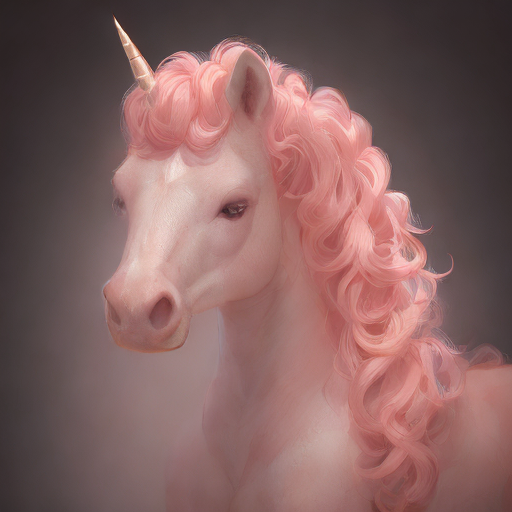

In [15]:
%%skip not $to_quantize.value

from IPython.display import display

prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4

images = int8_pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=8.0,
    height=512,
    width=512,
    generator=torch.Generator().manual_seed(1234567)
).images

display(images[0])

### Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [16]:
%%skip not $to_quantize.value

import time

validation_size = 10
calibration_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True)
validation_data = []
for idx, batch in enumerate(calibration_dataset):
    if idx >= validation_size:
        break
    prompt = batch["caption"]
    validation_data.append(prompt)

def calculate_inference_time(pipeline, calibration_dataset):
    inference_time = []
    pipeline.set_progress_bar_config(disable=True)
    for idx, prompt in enumerate(validation_data):
        start = time.perf_counter()
        _ = pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=8.0,
            height=512,
            width=512,
        )
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
        if idx >= validation_size:
            break
    return np.median(inference_time)

In [17]:
%%skip not $to_quantize.value

int8_latency = calculate_inference_time(int8_pipe, validation_data)
del int8_pipe
gc.collect()
ov_pipe = OVDiffusionPipeline.from_pretrained(model_path, device=device.value)
fp_latency = calculate_inference_time(ov_pipe, validation_data)
print(f"Performance speed up: {fp_latency / int8_latency:.3f}")

del ov_pipe
gc.collect();

Performance speed up: 1.357


### Compare UNet file size
[back to top ⬆️](#Table-of-contents:)


In [18]:
UNET_OV_PATH = model_path / "unet/openvino_model.xml"
UNET_INT8_OV_PATH = int8_model_path / "unet/openvino_model.xml"

if UNET_INT8_OV_PATH.exists():
    fp16_ir_model_size = UNET_OV_PATH.with_suffix(".bin").stat().st_size / 1024
    quantized_model_size = UNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 1024

    print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
    print(f"INT8 model size: {quantized_model_size:.2f} KB")
    print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 1678912.69 KB
INT8 model size: 841591.46 KB
Model compression rate: 1.995


## Run Text to image generation using OpenVINO GenAI
[back to top ⬆️](#Table-of-contents:)

[OpenVINO™ GenAI](https://github.com/openvinotoolkit/openvino.genai) is a library of the most popular Generative AI model pipelines, optimized execution methods, and samples that run on top of highly performant [OpenVINO Runtime](https://github.com/openvinotoolkit/openvino).

![](https://media.githubusercontent.com/media/openvinotoolkit/openvino.genai/refs/heads/master/src/docs/openvino_genai.svg)

This library is friendly to PC and laptop execution, and optimized for resource consumption. It requires no external dependencies to run generative models as it already includes all the core functionality.

`openvino_genai.Text2ImagePipeline` class supports inference of [Diffusers models](https://github.com/openvinotoolkit/openvino.genai/blob/master/src/docs/SUPPORTED_MODELS.md#text-2-image-models). For pipeline initialization, we should provide directory with converted by Optimum Intel pipeline and specify inference device. Optionally, we can provide configuration for LoRA Adapters using `adapter_config`. For starting generation process `generate` method should be used. Basically, it required to provide input text prompt for image generation. You can provide additional arguments like negative prompt, number of steps, guidance scale, image width and height to control generation process.

In [19]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [20]:
import ipywidgets as widgets

int8_can_be_used = int8_model_path.exists() and "GPU" not in device.value
use_quantized_model = widgets.Checkbox(value=int8_can_be_used, description="Use INT8 model", disabled=not int8_can_be_used)

use_quantized_model

Checkbox(value=True, description='Use INT8 model')

In [21]:
import openvino_genai as ov_genai

used_model_path = model_path if not use_quantized_model.value else int8_model_path

pipe = ov_genai.Text2ImagePipeline(used_model_path, device.value)

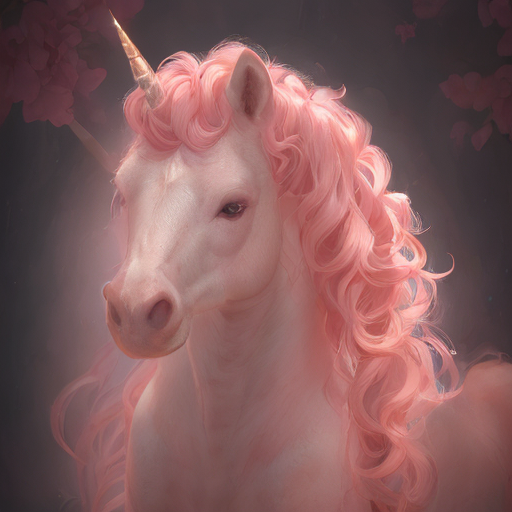

In [22]:
from PIL import Image
import torch
import openvino as ov


class Generator(ov_genai.Generator):
    def __init__(self, seed):
        ov_genai.Generator.__init__(self)
        self.generator = torch.Generator(device="cpu").manual_seed(seed)

    def next(self):
        return torch.randn(1, generator=self.generator, dtype=torch.float32).item()

    def randn_tensor(self, shape: ov.Shape):
        torch_tensor = torch.randn(list(shape), generator=self.generator, dtype=torch.float32)
        return ov.Tensor(torch_tensor.numpy())


prompt = "a beautiful pink unicorn, 8k"
num_inference_steps = 4

random_generator = Generator(1234567)

image_tensor = pipe.generate(prompt, width=512, height=512, num_inference_steps=4, num_images_per_prompt=1, generator=random_generator)

image = Image.fromarray(image_tensor.data[0])

image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [23]:
import random
import gradio as gr
import numpy as np

MAX_SEED = np.iinfo(np.int32).max


def randomize_seed_fn(seed: int, randomize_seed: bool) -> int:
    if randomize_seed:
        seed = random.randint(0, MAX_SEED)
    return seed


def generate(
    prompt: str,
    seed: int = 0,
    width: int = 512,
    height: int = 512,
    guidance_scale: float = 8.0,
    num_inference_steps: int = 4,
    randomize_seed: bool = False,
    progress=gr.Progress(track_tqdm=True),
):
    seed = randomize_seed_fn(seed, randomize_seed)
    random_generator = Generator(seed)
    result = pipe.generate(
        prompt, width=width, height=height, guidance_scale=guidance_scale, num_inference_steps=num_inference_steps, generator=random_generator
    )
    result = Image.fromarray(result.data[0])
    return result, seed

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/latent-consistency-models-image-generation/gradio_helper.py"
    )
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo_lcm

demo = make_demo_lcm(fn=generate)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/